# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.150107,True,8.566190
1,0.194132,False,-0.399928
2,0.125770,True,6.156362
3,-0.892743,False,-1.667940
4,0.220855,True,4.663174
...,...,...,...
995,0.635961,True,5.277604
996,0.427099,False,0.899574
997,-0.182966,False,-0.179757
998,2.231956,True,8.861955


<AxesSubplot:xlabel='v0'>

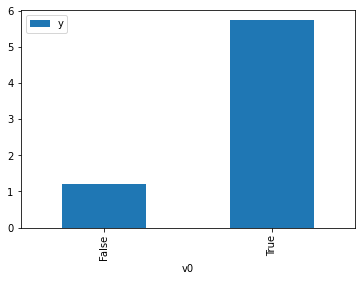

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

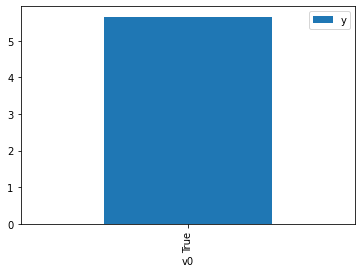

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,2.146170,False,6.422988,0.006378,156.791176
1,-1.761655,False,-3.056198,0.985329,1.014889
2,1.765596,False,2.974084,0.015564,64.252205
3,-0.032523,False,0.129383,0.527895,1.894317
4,-0.514159,False,-2.653901,0.777723,1.285805
...,...,...,...,...,...
995,0.942800,False,1.790180,0.099899,10.010105
996,1.202630,False,3.393589,0.056586,17.672337
997,0.692021,False,1.052235,0.167371,5.974767
998,-1.349496,False,-2.759362,0.961982,1.039521


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.393705,True,4.549113,0.710502,1.407456
1,-0.581491,True,4.682425,0.195931,5.103834
2,0.508834,True,5.079400,0.763236,1.310211
3,-0.297556,True,2.678525,0.323130,3.094730
4,0.664644,True,6.129785,0.823398,1.214480
...,...,...,...,...,...
995,-0.433298,True,2.897919,0.257132,3.889051
996,0.730158,True,5.985086,0.844842,1.183653
997,0.680798,True,5.743404,0.828892,1.206429
998,0.494645,True,6.031932,0.757110,1.320813


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.968
Model:                            OLS   Adj. R-squared (uncentered):              0.968
Method:                 Least Squares   F-statistic:                          1.533e+04
Date:                Thu, 18 Aug 2022   Prob (F-statistic):                        0.00
Time:                        18:12:47   Log-Likelihood:                         -1393.0
No. Observations:                1000   AIC:                                      2790.
Df Residuals:                     998   BIC:                                      2800.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.3059      0.037     62.805      0.000       2.234       2.378
x2             5.0434      0.050    101.367      0.000       4.946       5.141
==============================================================================
Omnibus:                        0.544   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.762   Jarque-Bera (JB):                0.419
Skew:                          -0.001   Prob(JB):                        0.811
Kurtosis:                       3.100   Cond. No.                         2.02
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""